In [1]:
from source_files import *
from plot_helpers import *
from raster_compare.plots import PlotBase

import query_helpers

import math

# Analysis

In [2]:
df = db_query_to_df()

positive_sfm = query_helpers.get_positive(df, 'sfm_snow_depth')

vegetation = ((positive_sfm.casi_class == 'Vegetation') | (positive_sfm.casi_class == 'Water'))
open_areas = ~vegetation

## Snow depth by elevation (positive SfM values)

In [26]:
max_sd = math.ceil(positive_sfm.sfm_snow_depth.max())
bins = np.concatenate((
    np.arange(0, 25.10, 0.10),
    np.arange(25, 35, 0.25),
    [max_sd]
))

elevation_bands = 10
elevation_min = positive_sfm[positive_sfm['elevation'] > 0].elevation.min()
elevation_min = elevation_min - elevation_min % elevation_bands
elevation_max = positive_sfm.elevation.max() + (elevation_bands - positive_sfm.elevation.max() % elevation_bands)
elevation_range = np.arange(elevation_min, elevation_max + elevation_bands, elevation_bands)

hist_opts = dict(
    bins=[bins, elevation_range],
    vmin=0,
    vmax=1000,
    cmin=1,
)

COLOR_BAR_ATTR = dict(right=0.9, rect=[0.91, 0.125, 0.03, 0.795])
FIGURE_SPECS = dict(figsize=(10, 3.5), dpi=150)
HIST2D_PLOT = dict(ncols=2, sharey=True, **FIGURE_SPECS)

def plot_hist2d(ax, x_data, y_data, **kwargs):
    if 'label' in kwargs:
        ax.set_xlabel(kwargs['label'] + ' ' + SNOW_DEPTH_LABEL)
    if 'title' in kwargs:
        ax.set_title(kwargs['title'])
    ax.tick_params(axis='x', direction='inout', length=10)
    ax.tick_params(axis='y', length=6)
    ax.set_facecolor('lightgrey')
    ax.xaxis.set_ticks_position('both')
    
    data = ax.hist2d(x_data, y_data, cmap=HIST_2D_CMAP, **kwargs)
    
    ax.set_xlim(0, 40)

    return data

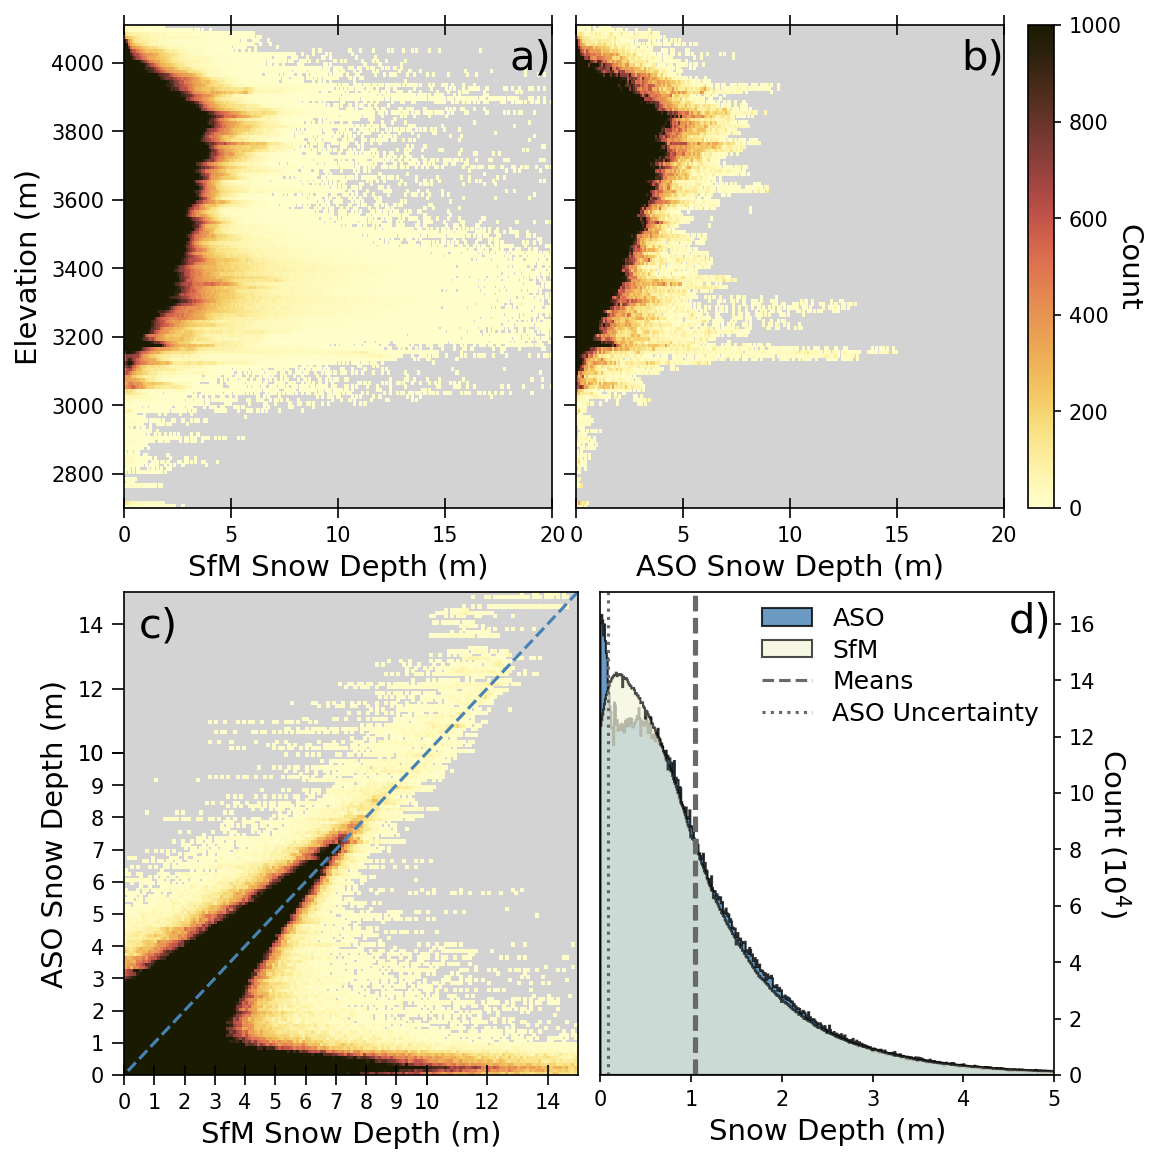

In [30]:
annotate_args = dict(xy=(18, 3980), fontsize=20)

fig = plt.figure(figsize=(8, 7), dpi=150)
gs_top = fig.add_gridspec(
    ncols=3, nrows=1, wspace=0.08, width_ratios=[.485, .485, .03], bottom=0.54, top=1
)
gs_bottom = fig.add_gridspec(
    ncols=2, nrows=1, bottom=0, top=0.46
)

ax1 = fig.add_subplot(gs_top[0, 0])
plot_hist2d(
    ax1,
    positive_sfm['sfm_snow_depth'],
    positive_sfm['elevation'],
    label='SfM',
    **hist_opts,
)
ax1.set_ylabel(ELEVATION_LABEL)
ax1.annotate('a)', **annotate_args)
ax1.set_xlim(0, 20)

ax2 = fig.add_subplot(gs_top[0, 1])
h2d_data_aso = plot_hist2d(
    ax2,
    positive_sfm['aso_snow_depth'],
    positive_sfm['elevation'],
    label='ASO',
    **hist_opts,
)

ax2.set_xlim(0, 20)
ax2.set_yticklabels([])
ax2.annotate('b)', **annotate_args)

color_bar = fig.colorbar(h2d_data_aso[3], cax=fig.add_subplot(gs_top[0, 2]))
color_bar.set_label(label='Count', rotation=270, labelpad=10)

ax3 = fig.add_subplot(gs_bottom[0, 0])
h1 = plot_hist2d(
    ax3,
    positive_sfm['sfm_snow_depth'],
    positive_sfm['aso_snow_depth'],
    bins=[bins, bins],
    vmin=0,
    vmax=150,
    cmin=1,
)
ax3.add_line(mlines.Line2D([-1, 16], [-1, 16], linestyle='--', color='steelblue'))
ticks = np.concatenate((np.arange(0, 11, 1), np.arange(10, 17, 2)))
ax3.set_xticks(ticks)
ax3.set_xlim(0, 15)
ax3.set_xlabel('SfM ' + SNOW_DEPTH_LABEL)
ax3.set_yticks(ticks)
ax3.set_ylim(0, 15)
ax3.set_ylabel('ASO ' + SNOW_DEPTH_LABEL)
ax3.xaxis.set_ticks_position('bottom')
ax3.annotate('c)', (0.5, 13.6), fontsize=20)

ax4 = fig.add_subplot(gs_bottom[0, 1])
Histogram.add_to_plot(
    ax4, 
    data=np.ma.asarray(positive_sfm['aso_snow_depth']), 
    label='ASO', 
    color='steelblue'
)
Histogram.add_to_plot(
    ax4, 
    data=np.ma.asarray(positive_sfm['sfm_snow_depth']), 
    label='SfM', 
    color='beige', 
    alpha=0.7
)
PRECISION_LINE = dict(linestyle='dotted', color='dimgrey')
ax4.axvline(x=0.08, **PRECISION_LINE)
ax4.set_xlim(0, 5)
ax4.set_xlabel(SNOW_DEPTH_LABEL)

PlotBase.move_yaxis_label_right(ax4)
PlotBase.format_axes_scientific(ax4, 'y', (4, 4))
ax4.legend(loc='upper right', )
handles, labels = ax4.get_legend_handles_labels()
handles.append(
    mlines.Line2D(
        [], [], 
        label='Means', 
        linestyle=Histogram.MEAN_LINE_STYLE['linestyle'],
        color=Histogram.MEAN_LINE_STYLE['color'],
    )
)
handles.append(
    mlines.Line2D(
        [], [], label='ASO Uncertainty', **PRECISION_LINE
    )
)
ax4.legend(
    handles=handles, fontsize='large', frameon=False, labelspacing=0.3, borderaxespad=0.2
)
ax4.annotate('d)', (4.5, 157000), fontsize=20);

annotate_args = dict(xy=(27, 3980), fontsize=20)

fig = plt.subplots(**FIGURE_SPECS)
gs1 = GridSpec(1, 2)
gs1.update(left=0., right=0.63, wspace=0.05)

ax1 = plt.subplot(gs1[0, 0])
h2d_data_sfm = plot_hist2d(
    ax1,
    positive_sfm['sfm_snow_depth'],
    positive_sfm['elevation'],
    label='SfM',
    **hist_opts,
)
ax1.set_ylabel(ELEVATION_LABEL)
ax1.annotate('a)', **annotate_args)
ax1.set_xlim(0, 30)

ax2 = plt.subplot(gs1[0, 1])
h2d_data_aso = plot_hist2d(
    ax2,
    positive_sfm['aso_snow_depth'],
    positive_sfm['elevation'],
    label='ASO',
    **hist_opts,
)
ax2.set_xlim(0, 30)
ax2.set_yticklabels([])
ax2.annotate('b)', **annotate_args)

gs2 = GridSpec(1, 1)
gs2.update(left=0.70, right=1)
ax3 = plt.subplot(gs2[0, 0])

h1 = plot_hist2d(
    ax3,
    positive_sfm['sfm_snow_depth'],
    positive_sfm['aso_snow_depth'],
    bins=[bins, bins],
    vmin=0,
    vmax=250,
    cmin=1,
)
ax3.add_line(mlines.Line2D([-1, 16], [-1, 16], linestyle='--', color='steelblue'))
ticks = np.concatenate((np.arange(0, 11, 1), np.arange(10, 17, 2)))
ax3.set_xticks(ticks)
ax3.set_xlim(0, 15)
ax3.set_xlabel('SfM ' + SNOW_DEPTH_LABEL)
ax3.set_yticks(ticks)
ax3.set_ylim(0, 15)
ax3.set_ylabel('ASO ' + SNOW_DEPTH_LABEL)
ax3.xaxis.set_ticks_position('bottom')
ax3.annotate('c)', (0.5, 13.6), fontsize=20)
PlotBase.insert_colorbar(ax3, h1[3], 'Count');

fig, (ax1, ax2) = plt.subplots(sharex=True, **HIST2D_PLOT)

bin_count_sum = np.count_nonzero(~np.isnan(h2d_data_sfm[0].T), axis=1)
ax1.axhline(y=3550, color='orange', linestyle='--')
ax1.plot(bin_count_sum, elevation_range[:-1])#, s=10)
ax1.set_ylabel(ELEVATION_LABEL)
ax1.set_xlabel('Number of bins')

bin_count_sum = np.count_nonzero(~np.isnan(h2d_data_aso[0].T), axis=1)
ax2.axhline(y=3550, color='orange', linestyle='--')
ax2.plot(bin_count_sum, elevation_range[:-1])#, s=10)
ax2.set_xlabel('Number of bins')

plt.suptitle('Bin count per elevation band', fontsize=16)
ax1.set_xlim(left=0);

fig, (ax1, ax2) = plt.subplots(**HIST2D_PLOT)

h1 = plot_hist2d(
    ax1,
    positive_sfm[vegetation]['sfm_snow_depth'],
    positive_sfm[vegetation]['elevation'],
    label='SfM',
    **hist_opts,
)
ax1.set_ylabel(ELEVATION_LABEL)

h2 = plot_hist2d(
    ax2,
    positive_sfm[vegetation]['aso_snow_depth'],
    positive_sfm[vegetation]['elevation'],
    label='ASO',
    **hist_opts,
)

plt.suptitle('Snow Depth in Vegetation')
PlotBase.insert_colorbar(ax2, h2[3], 'count', **COLOR_BAR_ATTR);

fig, (ax1, ax2) = plt.subplots(**HIST2D_PLOT)

h1 = plot_hist2d(
    ax1,
    positive_sfm[open_areas]['sfm_snow_depth'],
    positive_sfm[open_areas]['elevation'],
    label='SfM',
    **hist_opts,
)
ax1.set_ylabel(ELEVATION_LABEL)


h2 = plot_hist2d(
    ax2,
    positive_sfm[open_areas]['aso_snow_depth'],
    positive_sfm[open_areas]['elevation'],
    label='ASO',
    **hist_opts,
)
plt.suptitle('Snow Depth in Open Areas')
PlotBase.insert_colorbar(ax2, h2[3], 'count', **COLOR_BAR_ATTR);

# Snow Depth Difference (SfM - ASO)

In [5]:
cmap = plt.get_cmap("tab20c")
cmap = cmap(np.arange(4)*4, alpha=0.6)
blue = cmap[0].copy()
cmap[0], cmap[1] = cmap[1], blue  # Make snow blue, rock orange

In [6]:
casi_classes, classes_count = np.unique(df.casi_class.to_numpy(), return_counts=True)    

fig, (ax1, ax2) = plt.subplots(ncols=2, **FIGURE_SPECS)
bin_width = 0.1
bins = np.arange(
    math.floor(df.sd_difference.min()) - bin_width, 
    math.ceil(df.sd_difference.max()) + bin_width, 
    bin_width
)
stack = []

for casi_class in casi_classes:
    stack.append(df[df.casi_class == casi_class].sd_difference)
    
ax1.hist(
    stack,
    bins=bins,
    label=casi_classes,
    stacked=True,
    color=cmap,
)
ax1.axvline(0, color='black', linewidth=.4, alpha=1)
ax1.set_xlabel(SNOW_DEPTH_LABEL)
ax1.set_xlim(-5, 5)
ax1.set_ylabel('Count')
ax1.legend(loc='upper left')

patches, texts, autotexts = ax2.pie(
    classes_count, 
    labels=casi_classes, 
    colors=cmap,
    wedgeprops=dict(width=0.5, edgecolor='w'),
    textprops={'fontsize': 14},
    autopct='%1.1f%%')
ax2.axis('equal');

positive_sfm.sd_difference.agg([np.mean, np.median, np.std])

# SfM measurement errors

In [8]:
negative_sfm = query_helpers.get_negative(df, 'sfm_snow_depth')

In [32]:
max_bin = max(
    math.fabs(math.floor(negative_sfm.sfm_snow_depth.min())),
    math.ceil(positive_sfm.sfm_snow_depth.max())
)
bins = np.concatenate((
    np.arange(-max_bin, 0, 0.1),
    np.arange(0, 15.10, 0.10),
    np.arange(15, max_bin, 0.25),
))

hist_opts['bins'] = [bins, elevation_range]
HIST2D_PLOT = dict(ncols=2, sharey=True, **FIGURE_SPECS)

In [ ]:
fig, (ax1, ax2) = plt.subplots(**HIST2D_PLOT)

h1 = plot_hist2d(
    ax1,
    negative_sfm['sfm_snow_depth'],
    negative_sfm['elevation'],
    label='SfM',
    **hist_opts,
)
ax1.set_ylabel(ELEVATION_LABEL)
ax1.set_xlim(-35, 0.2)
ax1.yaxis.set_ticks_position('both')

h2 = plot_hist2d(
    ax2,
    negative_sfm['aso_snow_depth'],
    negative_sfm['elevation'],
    label='ASO',
    **hist_opts,
)
ax2.set_xlim(right=15)

fig.suptitle('Snow Depth measurement errors by Elevation')
PlotBase.insert_colorbar(ax2, h2[3], 'count', **COLOR_BAR_ATTR);

### SfM vs ASO depth

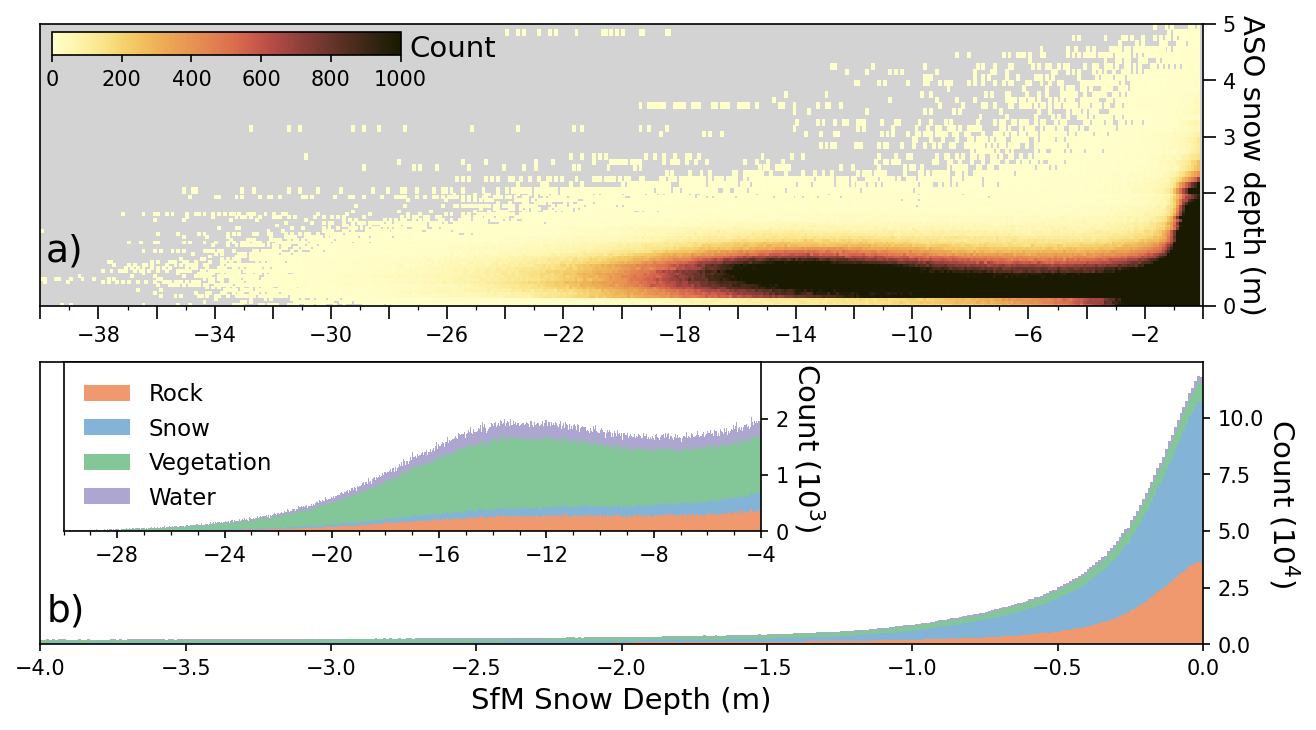

In [35]:
sfm_bins = np.arange(-max_bin, 0, 0.1)
aso_bins = np.concatenate((
    np.arange(0, 2.0, 0.05),
    np.arange(2, 10.1, 0.10)
))
xticks = np.concatenate((
    np.arange(-40, 1, 2),
))

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 5.2), dpi=150)

h1 = ax1.hist2d(
    negative_sfm['sfm_snow_depth'],
    negative_sfm['aso_snow_depth'],
    bins=[sfm_bins, aso_bins],
    cmap=HIST_2D_CMAP,
    vmin=0,
    vmax=1000,
    cmin=1,
)
ax1.set_facecolor('lightgrey')
ax1.tick_params(axis='both', length=6)
ax1.xaxis.set_ticks_position('bottom')

ax1.set_xlim(-40, 0)
ax1.set_xticks(xticks)
ax1.xaxis.set_minor_locator(MultipleLocator(1))
for label in ax1.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_ylim(0, 5)
ax1.set_ylabel('ASO snow depth (m)', rotation=270, labelpad=14)

ax1.annotate('a)', xy=(-39.8, 0.8), fontsize=18)

cax = ax1.inset_axes([0.01, 0.89, 0.3, .08])
cax.yaxis.set_label_position('right')
cax.yaxis.set_label_coords(1.15, 0.9)
colorbar = fig.colorbar(h1[3], cax=cax, orientation='horizontal')
colorbar.ax.set_ylabel('Count', rotation=0)

insert_start = -4

bins = np.concatenate((
    [math.floor(negative_sfm.sfm_snow_depth.min())],
    np.arange(-40, 0.01, 0.01),
))
stack = []

for casi_class in casi_classes:
    stack.append(negative_sfm[negative_sfm.casi_class == casi_class].sfm_snow_depth)

ax2.hist(
    stack,
    bins=bins,
    label=casi_classes,
    stacked=True,
    color=cmap,
#     histtype='step',
)
ax2.set_xlabel('SfM ' + SNOW_DEPTH_LABEL)
ax2.set_xlim(insert_start, bins.max())
PlotBase.format_axes_scientific(ax2, 'y', (4, 4))
PlotBase.move_yaxis_label_right(ax2)
ax2.annotate('b)', xy=(-3.98, 10000), fontsize=18)

ax3 = ax2.inset_axes([0.02, 0.4, 0.6, .6])
ax3.hist(
    stack,
    bins=bins,
    label=casi_classes,
    stacked=True,
    color=cmap,
)
ax3.set_xlim(-30, insert_start)
ax3.set_xticks(np.arange(-28, -3, 4))
ax3.xaxis.set_minor_locator(MultipleLocator(1))
ax3.set_ylim(top=3000)
ax3.set_yticks(np.arange(0, 3000, 1000))
PlotBase.format_axes_scientific(ax3, 'y', (3, 3))
PlotBase.move_yaxis_label_right(ax3)
ax3.legend(loc='upper left', fontsize=11, frameon=False);

### Open Areas

In [11]:
vegetation = ((negative_sfm.casi_class == 'Vegetation') | (negative_sfm.casi_class == 'Water'))
open_areas = ~vegetation

fig, (ax1, ax2) = plt.subplots(**HIST2D_PLOT)

h1 = plot_hist2d(
    ax1,
    negative_sfm[open_areas]['sfm_snow_depth'],
    negative_sfm[open_areas]['elevation'],
    label='SfM',
    **hist_opts,
)
ax1.set_ylabel(ELEVATION_LABEL)
ax1.set_xlim(-35, 0)

h2 = plot_hist2d(
    ax2,
    negative_sfm[open_areas]['aso_snow_depth'],
    negative_sfm[open_areas]['elevation'],
    label='ASO',
    **hist_opts,
)
ax2.set_xlim(right=15)

fig.suptitle('Snow Depth measurement errors by Elevation in open areas')
PlotBase.insert_colorbar(ax2, h2[3], 'count', **COLOR_BAR_ATTR);

### Vegetated areas

fig, (ax1, ax2) = plt.subplots(**HIST2D_PLOT)

h1 = plot_hist2d(
    ax1,
    negative_sfm[vegetation]['sfm_snow_depth'],
    negative_sfm[vegetation]['elevation'],
    label='SfM',
    **hist_opts,
)
ax1.set_ylabel(ELEVATION_LABEL)
ax1.set_xlim(-35, 0)

h2 = plot_hist2d(
    ax2,
    negative_sfm[vegetation]['aso_snow_depth'],
    negative_sfm[vegetation]['elevation'],
    label='ASO',
    **hist_opts,
)
ax2.set_xlim(right=15)

fig.suptitle('Snow Depth measurement errors by Elevation in vegetated areas')
PlotBase.insert_colorbar(ax2, h2[3], 'count', **COLOR_BAR_ATTR);

## SfM negative with aspect

In [ ]:
bin_min = math.floor(negative_sfm.sfm_snow_depth.min())
bins = np.arange(0, bin_min - 0.1, -0.2)
bins = np.flip(bins)

aspect_range = np.arange(0, 361, 1)

hist_opts = dict(
    bins=[aspect_range, bins],
    vmin=0,
    vmax=200,
    cmin=1,
)

fig = plt.figure(figsize=(15,8))
ax = fig.gca()
ax.set_facecolor('whitesmoke')
ha = ax.hist2d(
    negative_sfm['aspect'],
    negative_sfm['sfm_snow_depth'],
    **hist_opts,
)
PlotBase.insert_colorbar(ax, ha[3], 'Count')
ax.set_ylabel(SNOW_DEPTH_LABEL)
ax.set_xlabel('Aspect');

aspect_stats = negative_sfm[['sfm_snow_depth', 'aspect']].groupby('aspect')

aspect_count = aspect_stats.count()
aspect_medians = aspect_stats.median()
aspect_means = aspect_stats.mean()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14, 24))
ax1.scatter(aspect_count.index, aspect_count.sfm_snow_depth)
ax1.set_title('Aspect count')

ax2.scatter(aspect_medians.index, aspect_medians.sfm_snow_depth)
ax2.set_ylabel('Median SD difference')
ax2.set_title('Median differemnce by aspect');

ax3.scatter(aspect_means.index, aspect_means.sfm_snow_depth)
ax3.set_xlim(aspect_range.min(), aspect_range.max())
ax3.set_ylabel('Mean SD difference')
ax3.set_xlabel('Aspect in degree')
ax3.set_title('Mean difference by aspect');

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14, 24))
ax1.scatter(aspect_count.index, aspect_count.sfm_snow_depth)
ax1.set_title('Aspect count')

ax2.scatter(aspect_medians.index, aspect_medians.sfm_snow_depth)
ax2.set_ylabel('Median SD difference')
ax2.set_title('Median differemnce by aspect');

ax3.scatter(aspect_means.index, aspect_means.sfm_snow_depth)
ax3.set_xlim(aspect_range.min(), aspect_range.max())
ax3.set_ylabel('Mean SD difference')
ax3.set_xlabel('Aspect in degree')
ax3.set_title('Mean difference by aspect');

aspect_count.sort_values('sfm_snow_depth', ascending=False).head(10).sort_index()

### Vegetation and Water category masked out

In [ ]:
vegetation_free = negative_sfm.query('casi_class != "Vegetation" and casi_class != "Water"')

In [ ]:
vegetation_free_aspects = vegetation_free.groupby('aspect')
vegetation_free_aspects_median = vegetation_free_aspects.median()
vegetation_free_aspects_count = vegetation_free_aspects.count()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,24))
ax1.set_facecolor('whitesmoke')
ha = ax1.hist2d(
    vegetation_free['aspect'],
    vegetation_free['sfm_snow_depth'],
    **hist_opts,
)
ax1.set_ylabel(SNOW_DEPTH_LABEL)
ax1.set_title('Negative values with aspect - No Vegetation')

ax2.scatter(vegetation_free_aspects_median.index, vegetation_free_aspects_median.sfm_snow_depth)
ax2.set_title('Median difference by aspect - No Vegetation')
ax2.axvline(HILLSHADE_SNOW_ON['azimuth'], color='goldenrod', linestyle='--')
ax2.annotate('Snow On\n Sun Angle', xy=(HILLSHADE_SNOW_ON['azimuth'] + 1, -0.15))
ax2.axvline(HILLSHADE_SNOW_ON['azimuth'] + 180, color='dimgrey', linestyle='--')
ax2.annotate('Snow On\n Shade', xy=(HILLSHADE_SNOW_ON['azimuth'] + 181, -0.5))
ax2.axvline(HILLSHADE_SNOW_FREE['azimuth'], color='goldenrod', linestyle='--')
ax2.annotate('Snow Free\n Sun Angle', xy=(HILLSHADE_SNOW_FREE['azimuth'] + 1, -0.5))
ax2.axvline(HILLSHADE_SNOW_FREE['azimuth'] % 180, color='dimgrey', linestyle='--')
ax2.annotate('Snow Free\n Shade', xy=((HILLSHADE_SNOW_FREE['azimuth'] + 181) % 180, -0.15))
ax2.set_ylim(top=0)
ax2.set_ylabel('Median SD difference')

ax3.scatter(vegetation_free_aspects_count.index, vegetation_free_aspects_count.sfm_snow_depth)
ax3.set_title('Count of aspects - No Vegetation');
ax3.set_ylabel('Count')

ax3.set_xlim(aspect_range.min(), aspect_range.max())
ax3.set_xlabel('Aspect in degree');

# PlotBase.insert_colorbar(ax1, ha[3], 'count');

## SfM values with slope

In [ ]:
slope_range = np.arange(0, 91, 1)

hist_opts['bins'] = [slope_range, bins]

fig = plt.figure(figsize=(15,10))
ax = fig.gca()
ax.set_facecolor('whitesmoke')
hs = ax.hist2d(
    negative_sfm['slope'],
    negative_sfm['sfm_snow_depth'],
    **hist_opts
)
PlotBase.insert_colorbar(ax, hs[3], 'count')
ax.set_ylabel(SNOW_DEPTH_LABEL)
ax.set_xlabel('Slope')
ax.set_title('Negative values with slope');

slope_stats = negative_sfm[['sfm_snow_depth', 'slope']].groupby('slope')
slope_count = slope_stats.count()
slope_median = slope_stats.median()
slope_means = slope_stats.mean()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15, 24))

ax1.scatter(slope_count.index, slope_count.sfm_snow_depth)
ax1.set_title('Slope Count')

ax2.scatter(slope_median.index, slope_median.sfm_snow_depth)
ax2.set_ylabel('Median SD difference')
ax2.set_title('Median difference by slope')

ax3.scatter(slope_means.index, slope_means.sfm_snow_depth)
ax3.set_xlim(slope_range.min(), slope_range.max())
ax3.set_xlabel('Slope in degree')
ax3.set_ylabel('Mean SD difference')
ax3.set_title('Mean difference by slope');

In [ ]:
vegetation_free_slopes = vegetation_free.groupby('slope')
vegetation_free_slopes_median = vegetation_free_slopes.median()
vegetation_free_slopes_mean = vegetation_free_slopes.mean()
vegetation_free_slopes_count = vegetation_free_slopes.count()

max_spread = [math.tan(math.radians(slope)) for slope in vegetation_free_slopes_mean.index]

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,2.5), dpi=100)

ax1.plot(
    vegetation_free_slopes_median.index, 
    vegetation_free_slopes_median.sfm_snow_depth
)
ax1.add_line(mlines.Line2D([0, 55], [-1, -1], linestyle='--', color='orange'))
ax1.add_line(mlines.Line2D([55, 55], [-1, -20], linestyle='--', color='orange'))
ax1.axvline(84, linestyle='--', color='orange')
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.set_xlabel('Slope (degrees)')
ax1.set_xlim(left=0)
ax1.set_xticks(np.arange(0, 91, 10))
ax1.set_ylim(-18, 0.2)
ax1.set_yticks(np.arange(0, -20, -4))
ax1.set_ylabel('Median Depth (m)');

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(14,21))

ax1.plot(
    vegetation_free_slopes_median.index, 
    vegetation_free_slopes_median.sfm_snow_depth,
    color='deepskyblue', label='Median'
)
ax1.add_line(mlines.Line2D([0, 55], [-1, -1], linestyle='--', color='orange'))
ax1.add_line(mlines.Line2D([55, 55], [-1, -20], linestyle='--', color='orange'))
ax1.axvline(84, linestyle='--', color='orange')
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.set_ylim(-18, 0.2)
ax1.set_yticks(np.arange(0, -20, -2))
ax1.set_ylabel('SD difference')

# ax1_1 = ax1.twinx()
# ax1_1.spines["right"].set_position(("axes", 1.1))
# ax1_1.plot(
#     vegetation_free_slopes_mean.index, 
#     vegetation_free_slopes.point_spread_snow_on.mean(), 
#     label='Point Spread Snow On',
#     marker=''
# )

ax1_2 = ax1.twinx()

ax1_2.plot(
    vegetation_free_slopes_count.index, vegetation_free_slopes_count.sfm_snow_depth,
    color='indigo',
    label='Number of slopes',
)
ax1_2.set_xlabel('Slope in degree')
ax1_2.set_xlim(slope_range.min(), slope_range.max())
ax1_2.set_ylim(bottom=0)
ax1_2.set_ylabel('Count')

ax1.legend()

ax2.plot(
    vegetation_free_slopes_mean.index, 
    max_spread,
    label='Max Spread for Slope Angle'
)
ax2.plot(
    vegetation_free_slopes_mean.index, 
    vegetation_free_slopes_mean.point_spread_snow_on,
    label='Mean Point Spread Snow On'
)
ax2.plot(
    vegetation_free_slopes_mean.index, 
    vegetation_free_slopes_mean.point_spread_snow_free,
    label='Mean Point Spread Snow Free'
)
ax2.axvline(55, linestyle='--', color='orange')
ax2.axvline(84, linestyle='--', color='orange')
ax2.set_ylabel('Meter')
ax2.legend()

ax3.plot(
    vegetation_free_slopes_mean.index, 
    vegetation_free_slopes_mean.sfm_point_count_snow_free, 
    label='Point Count Snow Free'
)
ax3.plot(
    vegetation_free_slopes_mean.index, 
    vegetation_free_slopes_mean.sfm_point_count_snow_on, 
    label='Point Count Snow On'
)
ax3.axvline(55, linestyle='--', color='orange')
ax3.axvline(84, linestyle='--', color='orange')
ax3.set_ylim(bottom=-.2)
ax3.set_ylabel('Point Count')
ax3.legend();

## ASO snow depth by slope
### Vegetation free

In [ ]:
bin_max = math.ceil(vegetation_free.aso_snow_depth.max())
bins = np.arange(0, bin_max + 0.1, 0.1)

hist_opts['bins'] = [slope_range, bins]

fig, ax1 = plt.subplots(
    figsize=(10, 6),
    dpi=150,
)
ax1.set_facecolor('whitesmoke')
ha = ax1.hist2d(
    vegetation_free.slope,
    vegetation_free.aso_snow_depth,
    **hist_opts,
)
ax1.set_ylabel(SNOW_DEPTH_LABEL)
ax1.set_title('ASO snow depth by slope');

### Basin wide

In [ ]:
bin_max = math.ceil(df.aso_snow_depth.max())
bins = np.arange(0, bin_max + 0.1, 0.1)

hist_opts['bins'] = [slope_range, bins]

fig, ax1 = plt.subplots(
    figsize=(13, 6),
    dpi=150,
)
ax1.set_facecolor('whitesmoke')
ha = ax1.hist2d(
    df.slope,
    df.aso_snow_depth,
    **hist_opts,
)
ax1.set_ylabel(SNOW_DEPTH_LABEL)
ax1.set_title('ASO snow depth by slope');